In [1]:
import EDEDE
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

Could not load cython functions. Some functionality might be broken.
Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


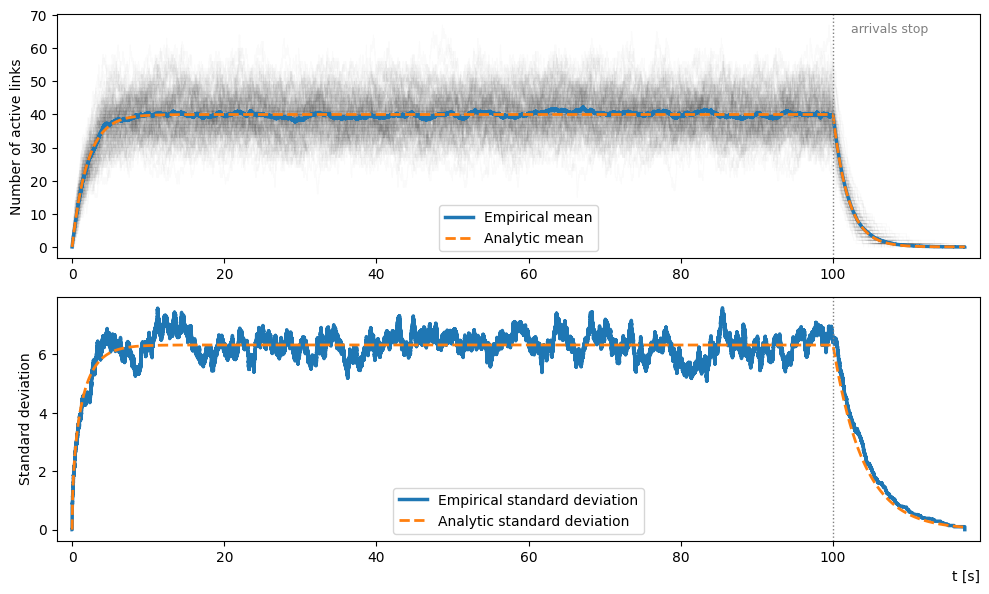

In [ ]:
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2, 1)

# --- Params (adjust as needed) ---
n_samples = 100
t_start, t_end = 0.0, 100.0
alpha_each = 0.02
lw_each = 0.8

density = 20    
inter_tau = 2.0

tail_factor = 2     # plot analytic curves up to t_end + tail_factor

# --- Analytic mean m(t) ---
def m_of_t(t, density, inter_tau, t_start, t_end):

    if t < t_start:
        return 0.0
    elif t <= t_end:
        return density * inter_tau * (1.0 - np.exp(-(t - t_start)/inter_tau))
    else:
        return density * inter_tau * (np.exp(-(t - t_end)/inter_tau) - np.exp(-(t - t_start)/inter_tau))

# Helper: full-span right-continuous step for one realization
def step_full_span(change_times, counts_after, t_start, t_end):
    if len(change_times) == 0:
        return [t_start, t_end], [0, 0]
    t_plot_end = max(t_end, change_times[-1])  # key line
    xs = [t_start] + list(change_times) + [t_plot_end]
    ys = [0] + list(counts_after) + [counts_after[-1]]
    return xs, ys

# --- Draw samples, store starts/ends for averaging ---
starts_list, ends_list = [], []

# Plot1: Trajectories and Means
ax_a = fig.add_subplot(gs[0, 0])

for sample in range(n_samples):
    n_events, start_times, end_times = EDEDE.EDEDE(
        density=density, inter_tau=inter_tau, t_start=t_start, t_end=t_end, seed=42+sample
    )
    starts_list.append(start_times)
    ends_list.append(end_times)

    ct, ca = EDEDE.activity_EDEDE(start_times, end_times)
    xs, ys = step_full_span(ct, ca, t_start, t_end)
    ax_a.step(xs, ys, where="post", color="k", alpha=alpha_each, linewidth=lw_each)

# --- Build union of change times across all samples (include endpoints) ---
times_all = set([t_start, t_end])
for starts, ends in zip(starts_list, ends_list):
    times_all.update(starts)
    times_all.update(ends)
times_all = sorted(times_all)
t_last = times_all[-1]          # last time any change happens (often > t_end)
t_max  = t_last                 # use this for the expected/analytic curves

# --- Compute empirical counts at each time for each sample (right-continuous) ---
counts_mat = np.zeros((n_samples, len(times_all)), dtype=float)

for i, (starts, ends) in enumerate(zip(starts_list, ends_list)):
    delta = defaultdict(int)
    for s in starts: delta[s] += 1
    for e in ends:   delta[e] -= 1
    cur = 0
    row = counts_mat[i]
    for j, t in enumerate(times_all):
        cur += delta.get(t, 0)  # count AFTER time t (right-continuous)
        row[j] = cur

# --- Empirical mean and std over samples ---
if n_samples > 1:
    emp_mean = counts_mat.mean(axis=0)
    emp_std  = counts_mat.std(axis=0, ddof=1)
else:
    emp_mean = counts_mat[0]
    emp_std  = np.zeros_like(emp_mean)

# --- Analytic mean and ±√m(t) band on a grid up to the last time ---
t_dense_full = np.linspace(t_start, t_max, 1600)
m_dense_full = np.array([m_of_t(t, density, inter_tau, t_start, t_end) for t in t_dense_full])
sd_dense_full = np.sqrt(np.clip(m_dense_full, 0, None))

# --- Plot means (empirical up to t_end; analytic) ---
ax_a.step(times_all, emp_mean, where="post", linewidth=2.5, label="Empirical mean")
ax_a.plot(t_dense_full, m_dense_full, "--", linewidth=2, label="Analytic mean")

# Visual cue where arrivals stop
ax_a.axvline(t_end, color="gray", linestyle=":", linewidth=1.0)
ax_a.text(t_end + 0.02*(t_max - t_start), ax_a.get_ylim()[1]*0.92, "arrivals stop", color="gray", fontsize=9)

# Plot2: Standard deviation (empirical up to t_end; analytic)
ax_b = fig.add_subplot(gs[1, 0])
ax_b.step(times_all, emp_std, where="post", linewidth=2.5, label="Empirical standard deviation")
ax_b.plot(t_dense_full, sd_dense_full, "--", linewidth=2, label="Analytic standard deviation")


ax_a.set_xlim(-2, t_max + tail_factor)
ax_b.set_xlim(-2, t_max + tail_factor)

ax_b.axvline(t_end, color="gray", linestyle=":", linewidth=1.0)

# --- Decorate ---
ax_b.set_xlabel("t [s]", loc="right")
ax_a.set_ylabel("Number of active links")
ax_b.set_ylabel("Standard deviation")

ax_a.legend()
ax_b.legend()
plt.tight_layout()
#plt.savefig('/Users/samuelkoovely/Desktop/fig_EDEDE/trajectories_m_sd.pdf', format='pdf')
plt.show()